In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横128pxにリサイズする）

import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(128, 128),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(128, 128),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-06 18:35:45.544804: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[ 83.      ,  70.      ,  61.      ],
          [ 83.75781 ,  70.75781 ,  62.13672 ],
          [ 84.92969 ,  71.92969 ,  63.89453 ],
          ...,
          [ 79.68359 ,  66.61328 ,  58.71875 ],
          [ 74.41016 ,  60.16797 ,  54.03125 ],
          [ 71.      ,  56.      ,  51.      ]],
 
         [[ 84.515625,  71.515625,  62.515625],
          [ 85.12987 ,  72.12987 ,  63.508774],
          [ 86.07973 ,  73.07973 ,  65.04457 ],
          ...,
          [ 78.32782 ,  68.28876 ,  61.085434],
          [ 75.71857 ,  64.50763 ,  57.95204 ],
          [ 74.03125 ,  62.0625  ,  55.92578 ]],
 
         [[ 86.859375,  73.859375,  64.859375],
          [ 87.2516  ,  74.2516  ,  65.63051 ],
          [ 87.85814 ,  74.85814 ,  66.82298 ],
          ...,
          [ 76.23126 ,  70.8797  ,  64.745255],
          [ 77.74188 ,  71.218445,  64.01512 ],
          [ 78.71875 ,  71.4375  ,  63.54297 ]],
 
         ...,
 
         [[148.89453 , 136.89453 , 122.96484 ],
          [150.476

In [3]:
# 分類名（cat／dog）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

2025-08-06 18:35:49.728142: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


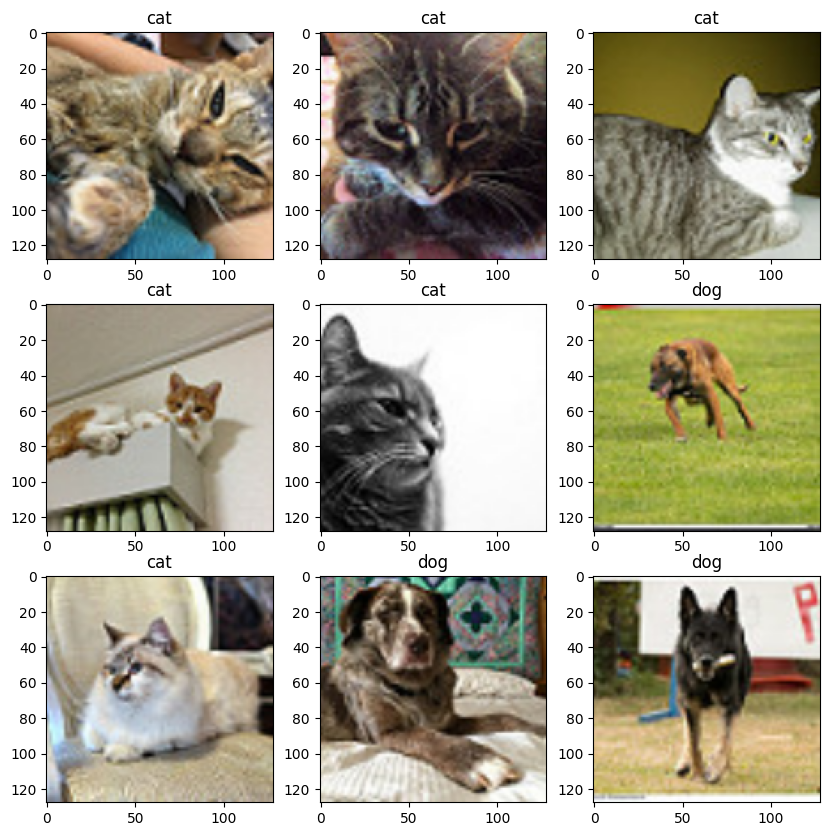

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

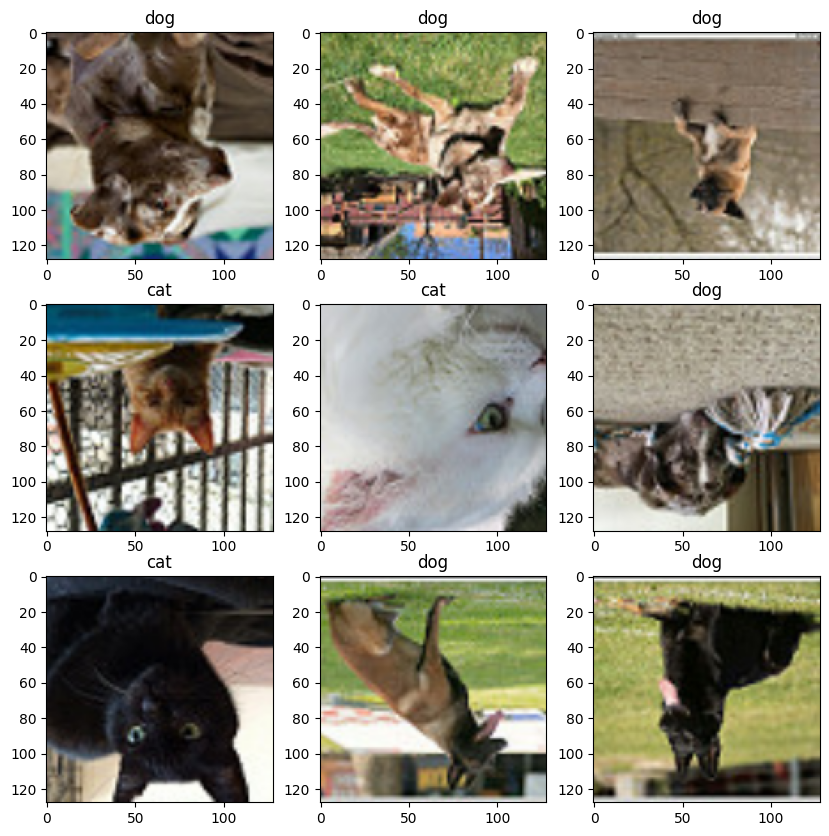

In [11]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [12]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(128, 128, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(128, 128, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [14]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [15]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [16]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8167 - loss: 0.3964
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9261 - loss: 0.1977
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9472 - loss: 0.1502
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9628 - loss: 0.1205
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9744 - loss: 0.1002
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9789 - loss: 0.0858
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9833 - loss: 0.0745
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9867 - loss: 0.0657
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9900 - loss: 0.0597
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9894 - loss: 0.0522
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9939 - loss: 0.0462
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy:

In [17]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


In [18]:
# 分類した結果を確認する
pred_data

array([[1.5093137e-03],
       [8.9560859e-03],
       [1.8821812e-04],
       [8.0818907e-05],
       [1.4784271e-04],
       [2.4347981e-05],
       [1.1176036e-04],
       [2.1715481e-04],
       [2.4594206e-05],
       [4.3746334e-04],
       [1.3339054e-04],
       [1.3937629e-03],
       [7.2262192e-05],
       [9.6046984e-05],
       [1.4764574e-04],
       [8.1720980e-05],
       [2.1262381e-03],
       [1.7136555e-05],
       [9.1398903e-04],
       [1.3334374e-04],
       [4.3640585e-04],
       [3.4851540e-02],
       [1.9815640e-04],
       [1.5565488e-04],
       [6.7601367e-03],
       [4.5572390e-04],
       [3.1632997e-02],
       [9.1747541e-05],
       [1.5654409e-03],
       [9.2732575e-05],
       [1.1689037e-03],
       [8.7596677e-02],
       [3.6312009e-05],
       [2.1874913e-04],
       [1.1757497e-03],
       [3.3577719e-01],
       [9.5151134e-02],
       [1.6235231e-03],
       [2.3095498e-02],
       [1.0912263e-02],
       [5.4243812e-04],
       [4.526854

In [19]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9900 - loss: 0.0381


[0.03813688084483147, 0.9900000095367432]